In [1]:
%pip install gdown
%pip install lightgbm
import pandas as pd
import lightgbm as lgb
import gdown
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\test.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\train.csv',
 'c:\\Users\\adria\\OneDrive\\Documenti\\Università\\Foundation of data science\\project\\Dataset\\training.csv']

**Nurbek**

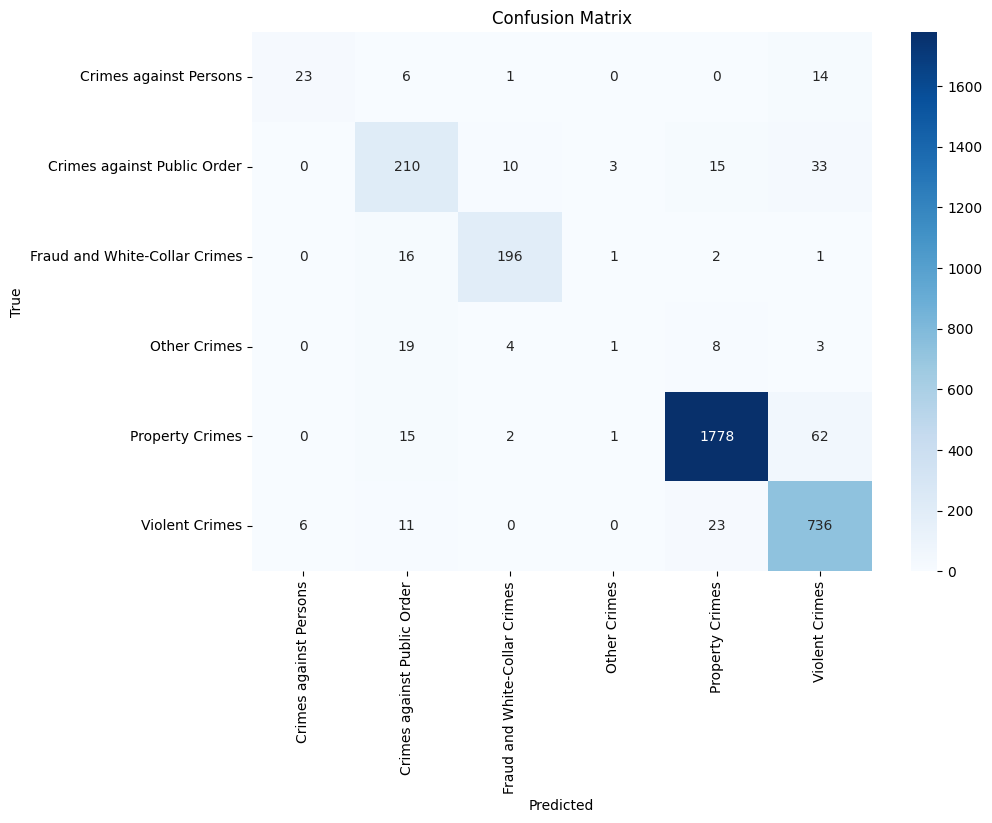

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.79      0.52      0.63        44
  Crimes against Public Order       0.76      0.77      0.77       271
Fraud and White-Collar Crimes       0.92      0.91      0.91       216
                 Other Crimes       0.17      0.03      0.05        35
              Property Crimes       0.97      0.96      0.97      1858
               Violent Crimes       0.87      0.95      0.91       776

                     accuracy                           0.92      3200
                    macro avg       0.75      0.69      0.71      3200
                 weighted avg       0.91      0.92      0.92      3200
 

Accuracy:  0.92


In [2]:
# Load datasets
train_df = pd.read_csv("Dataset/training.csv")
test_df = pd.read_csv("Dataset/test.csv")

# Step 1: Data preprocessing
# Encode the categorical target variable
label_encoder = LabelEncoder()
train_df['Crime_Category'] = label_encoder.fit_transform(train_df['Crime_Category'])

# Separate features and target variable
X = train_df.drop(columns=['Crime_Category'])
y = train_df['Crime_Category']

# Split features into numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Handle missing values
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())
X[categorical_columns] = X[categorical_columns].fillna('Unknown')

# Convert categorical features to numeric
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 2: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the LightGBM Dataset
train_set = lgb.Dataset(X_train, label=y_train)

# Step 4: Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# Step 5: Train the model
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# Step 6: Predictions
y_pred_proba = bst.predict(X_test)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class predictions

# Step 7: Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Classification report (precision, recall, F1-score)
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy: ", accuracy)